# Batch (parallel) Demand Forecasting using PyTorch Forecasting


**Batch training, tuning, and deploying** are common tasks in machine learning. They require training simple models, on data batches, typcially corresponding to different locations, products, etc. Batch training can take less time to process all the data at once, but only if those batches can run in parallel!

This notebook showcases how to conduct batch forecasting using the <a href="https://github.com/ray-project/ray_lightning">Ray Lightning plugin</a> (which runs on top <a href="https://docs.ray.io">Ray</a>) to speed up training and inference of Google's <a href="https://github.com/google-research/google-research/tree/master/tft">TemporalFusionTransformer</a> algorithm for RNN with LSTM, which has been adapted by <a href="https://pytorch-forecasting.readthedocs.io">PyTorch Forecasting</a>, which in turn is built on <a href="https://pytorch-lightning.readthedocs.io">PyTorch Lightning</a>. PyTorch Lightning is a set of APIs to simplify PyTorch, similar to the relationship of Keras to TensorFlow.

<img src="../../../../AnyscaleDemos/ray_air_demos/images/embarrassingly_parallel.png" style="width: 50%"/>

For the data, we will use the [NYC Taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). This popular tabular dataset contains historical taxi pickups by timestamp and location in NYC.

For the training, we will train a separate forecasting model to predict #pickups at each location in NYC at hourly level for the next week. Specifically, we will train multiple TemporalFusionTransformer models using different hyperparameters, on different segments of data, to find the best model per segment of data.  For convenience, we have already clustered the `pickup_location_id` column in the dataset into 2 groups (or clusters of data).

**Demo notes** <br>
See [README](https://github.com/christy/AnyscaleDemos/tree/main/forecasting_demos#-setup-instructions-for-anyscale) for instructions how to run this notebook on Anyscale.

# Contents

In this this tutorial, you will learn how to:
 1. [Define how to load and prepare Parquet data](#prepare_data) 
 2. [Define a Trainable (callable) function](#define_trainable)
 3. [Run batch training and inference with Ray Tune](#run_tune_search)
 4. [Load a model from checkpoint](#load_checkpoint)
 5. [Create a validation forecast from restored checkpoint model](#create_inference)
 6. [Deploy a model from checkpoint using Ray Serve](#deploy_model)


# Walkthrough

```{tip}
Prerequisite for this notebook: Read the [Key Concepts](https://docs.ray.io/en/latest/tune/key-concepts.html) page for Ray Tune.
```

Let us start by importing a few required libraries, including open-source [Ray](https://github.com/ray-project/ray) itself!

In [1]:
!python --version
import os, random
import typing
num_cpu = os.cpu_count()

print(f"Number of CPUs in this system: {num_cpu}")
from typing import Tuple, List, Union, Optional, Callable
from datetime import datetime, timedelta
import time
import pandas as pd
import numpy as np

print(f"numpy: {np.__version__}")
import matplotlib.pyplot as plt
import pickle

%matplotlib inline
import pyarrow
import pyarrow.parquet as pq
import pyarrow.dataset as pds

print(f"pyarrow: {pyarrow.__version__}")


Python 3.8.13
Number of CPUs in this system: 8
numpy: 1.23.4
pyarrow: 10.0.1


In [2]:
# import GPUtil #GPU status from NVIDA GPUs
# len(GPUtil.getGPUs())

In [3]:
import ray

if ray.is_initialized():
    ray.shutdown()
ray.init()

2023-01-04 21:46:52,475	INFO worker.py:1230 -- Using address localhost:9031 set in the environment variable RAY_ADDRESS
2023-01-04 21:46:52,476	INFO worker.py:1352 -- Connecting to existing Ray cluster at address: 172.31.129.29:9031...
2023-01-04 21:46:52,508	INFO worker.py:1529 -- Connected to Ray cluster. View the dashboard at https://console.anyscale-staging.com/api/v2/sessions/ses_bv6cqua3a9m1ir4yiuzkwmrw/services?redirect_to=dashboard 


Python version:,3.8.13
Ray version:,2.2.0
Dashboard:,http://console.anyscale-staging.com/api/v2/sessions/ses_bv6cqua3a9m1ir4yiuzkwmrw/services?redirect_to=dashboard


In [4]:
print(ray.cluster_resources())

{'node:172.31.167.50': 1.0, 'CPU': 56.0, 'memory': 274877906944.0, 'object_store_memory': 8589934592.0, 'node:172.31.129.29': 1.0, 'node:172.31.150.237': 1.0, 'node:172.31.252.105': 1.0}


In [5]:
# Import forecasting libraries.
import torch  #Pytorch
import pytorch_lightning as pl  #PyTorch Lightning convenience APIs for PyTorch
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_forecasting as ptf #PyTorch Forecasting convenience APIs for PyTorch Lightning
pl.seed_everything(415)  # Set global random seed
# PyTorch visualization uses Tensorboard
# import tensorflow as tf #Tensorflow
import tensorboard as tb  #Tensorboard
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile  #compatibility for PyTorch

print(f"torch: {torch.__version__}")
print(f"PyTorch Lightning: {pl.__version__}")
print(f"pytorch forecasting: {ptf.__version__}")
print(f"tensorboard: {tb.__version__}")

# Import ray libraries.
import ray_lightning
from ray_lightning import RayStrategy
from ray_lightning.tune import get_tune_resources, TuneReportCheckpointCallback
from ray import air, tune, serve
from ray.tune.schedulers import ASHAScheduler, PopulationBasedTraining

/home/ray/anaconda3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/ray/anaconda3/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")
Global seed set to 415


torch: 1.13.1+cu117
PyTorch Lightning: 1.6.5
pytorch forecasting: 0.10.3
tensorboard: 2.10.0


In [6]:
# For benchmarking purposes, we can print the times of various operations.
# In order to reduce clutter in the output, this is set to False by default.
PRINT_TIMES = False

def print_time(msg: str):
    if PRINT_TIMES:
        print(msg)

# To speed things up, we’ll only use a small subset of the full dataset consisting of two last months of 2019.
# You can choose to use the full dataset for 2018-2019 by setting the SMOKE_TEST variable to False.
SMOKE_TEST = False

## Define how to load and prepare Parquet data <a class="anchor" id="prepare_data"></a>

First, we need to load some data. Since the NYC Taxi dataset is fairly large, we will filter files first into a PyArrow dataset. And then in the next cell after, we will filter the data on read into a PyArrow table and convert that to a pandas dataframe.

```{tip}
Use PyArrow dataset and table for reading or writing large parquet files, since its native multithreaded C++ adapter is faster than pandas read_parquet, even using engine=pyarrow.
```

In [7]:
# Define some global variables.
TARGET = "trip_quantity"
FORECAST_LENGTH = 28
# TODO: Change this according to where your git files are located.
data_dir = "/home/ray/christy-air/forecasting_demos/Ray_v2/data"
# data_dir = "~/Documents/christy_public_temp/AnyscaleDemos/forecasting_demos/Ray_v2/data"
data_dir = os.path.expanduser(data_dir)
DATA_FILENAME = data_dir + "/clean_taxi_hourly_clustered.parquet"

# Use smoke testing or not.
sample_clusters = ["erratic"] if SMOKE_TEST else ["smooth", "erratic"]

# Display what data will be used.
print(f"data file: {DATA_FILENAME}")
print(f"Clusters: {sample_clusters}")

data file: /home/ray/christy-air/forecasting_demos/Ray_v2/data/clean_taxi_hourly_clustered.parquet
Clusters: ['smooth', 'erratic']


In [8]:
############
# STEP 1. Define Python functions to 
#         a) read and prepare data.
############

# Function to read a pyarrow.Table object using pyarrow parquet, pq
def read_data_from_clean(
    file: str, 
    sample_id: np.int32) -> pd.DataFrame:

    df = pq.read_table(
        file,
        filters=[
            ("pulocationid", "not in", ['264', '265', '199']),
            ("ts_type", "=", sample_id),
        ],
        columns=[
            "time_idx",
            "pulocationid",
            "day_hour",
            "trip_quantity",
            "ts_type",
        ],
    ).to_pandas()
    return df

def prepare_data_from_clean(
    file: str, 
    sample_cluster_id: str) -> pd.DataFrame:

    # Load data from clean sample.
    df = read_data_from_clean(file, sample_cluster_id)
    df.rename(columns={"pulocationid": "pickup_location_id"}, inplace=True)
    df['trip_quantity'] = df['trip_quantity'].astype(np.float32)

    # Abort Tune to avoid Tune Error if df has too few rows
    if df.shape[0] < FORECAST_LENGTH:
        print_time(
            f"Location {sample_cluster_id} has only {df.shape[0]} rows"
        )
        session.report(dict(error=None))
        return None
    else:
        return df


## Define a Trainable (callable) function <a class="anchor" id="define_trainable"></a>



Next, we define a trainable function, called `train_model()`, in order to train and evaluate a model on a data partition. This function will be called *in parallel for every permutation* in the Tune search space! Inside this trainable function:
- 📖 The input must include a `config` dictionary argument. 
- 📈 Inside the function, the tuning metric (a model's loss or error) must be calculated and reported using session.report().
- ✔️ Optionally [checkpoint](https://docs.ray.io/en/master/ray-air/key-concepts.html#checkpoints) (save) the model for fault tolerance and easy deployment later.

```{tip}
Ray Tune has two ways of defining a trainable, namely the [Function API](https://docs.ray.io/en/latest/tune/api_docs/trainable.html#trainable-docs) and the Class API. Both are valid ways of defining a trainable, but *the Function API is generally recommended*.
```

In [9]:
############
# STEP 1.  Define Python functions to 
#          b) train and evaluate a model.
############

# Convert pandas data to PyTorch tensors.
def convert_pandas_pytorch_timeseriesdata(
    input_data_pandas_df:pd.DataFrame, 
    config:dict
) -> typing.Union['pytorch_forecasting.data.timeseries.TimeSeriesDataSet',
                  'torch.utils.data.dataloader.DataLoader']:

    """Converts pandas dataframe into TimeSeries folded tensors following 
       the backtesting technique.  A generator for doing the folding is 
       per batch also created.  One for the training data.  
       Another for the validation data.  

    Inputs:
        pd.DataFrame: All the input data
        dict: config is a configuration file containing hard-coded settings.

    Returns:
        'pytorch_forecasting.data.timeseries.TimeSeriesDataSet': training data
        'torch.utils.data.dataloader.DataLoader': training data loader
        'torch.utils.data.dataloader.DataLoader': validation data loader
    """
    
    # specify data parameters
    FORECAST_HORIZON = config.get("forecast_horizon", 168)
    CONTEXT_LENGTH = config.get("context_length", 63)
    BATCH_SIZE = config.get("batch_size", 32)
    NUM_TRAINING_WORKERS = config.get("num_training_workers", 4)
    id_col_name = "pickup_location_id"
    target_value = "trip_quantity"
    
    df = input_data_pandas_df.copy()
    
    # define forecast horizon and training cutoff
    max_prediction_length = FORECAST_HORIZON  #decoder length = 1 week forecast horizon
    max_encoder_length = CONTEXT_LENGTH  # window or context length
    training_cutoff = df["time_idx"].max() - max_prediction_length 

    # convert pandas to PyTorch tensor
    training_data = ptf.data.TimeSeriesDataSet(
        df[lambda x: x.time_idx <= training_cutoff],
        allow_missing_timesteps=True,
        time_idx="time_idx",
        target=target_value,
        group_ids=[id_col_name],
        min_encoder_length=5,  # min 5 historical values must exist
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=[id_col_name],
        # static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
        static_reals=[],
        time_varying_known_categoricals=["day_hour"],
        # group of categorical variables can be treated as one variable
        # variable_groups={"special_days": special_days},  
        time_varying_known_reals=["time_idx", ],
                            # "mean_item_loc_weekday",
                            # "binned_max_item"],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=[target_value,],

        # https://pytorch-forecasting.readthedocs.io/en/v0.2.4/_modules/pytorch_forecasting/data.html
        target_normalizer=ptf.data.GroupNormalizer(
            groups=["pickup_location_id"], 
            transformation="softplus"  #forces positive values
        ), 
        add_relative_time_idx=True, # add as feature
        add_target_scales=True, # add avg target_value as feature
        add_encoder_length=True, # add as feature
    )
    
    # create PyTorch dataloader for training
    train_loader = training_data\
                        .to_dataloader(
                            train=True, 
                            batch_size=BATCH_SIZE, 
                            num_workers=NUM_TRAINING_WORKERS)
    
    # create validation PyTorch data 
    # (predict=True) means make do inference using the validation data
    val_dataset = ptf.data.TimeSeriesDataSet\
                    .from_dataset(
                        training_data, 
                        data=df, 
                        predict=True, 
                        stop_randomization=True)

    # create PyTorch dataloaders for inference on validation data
    validation_loader = val_dataset\
                    .to_dataloader(
                        train=False, 
                        batch_size=BATCH_SIZE * 10, 
                        num_workers=NUM_TRAINING_WORKERS)
    
    # return original df converted to PyTorch tensors, and pytorch loaders
    return training_data, train_loader, validation_loader

################
# calculate WQL, MAE
# note: to get a single item quantile prediction:
# example: quantile p50 for itemid="140"
# y_quantiles[1].detach().cpu()[43, : x["decoder_lengths"][43]] 
# raw predictions are a dictionary from which quantiles can be extracte
# TIP:  Use x to figure out mappings indexes to locations [141, 43, 144]
################
def evaluate_model(y_actual:'torch.Tensor', 
             y_quantiles:'torch.Tensor', 
             quantile_list:list)->'torch.Tensor':
    """Calculate weighted quantile loss given actuals, quantile predictions,
       and list of desired quantiles to average over.
    Inputs:
        'torch.Tensor': y_actual is a tensor of actual values 
        'torch.Tensor': y_quantiles is a tensor of quantile predictions
        'list': List of quantiles to average over

    Returns:
        'torch.Tensor': weighted quantile loss over all the desired quantiles
    """

    assert not y_actual.requires_grad
    
    all_losses = []
    for i, q in enumerate(quantile_list):
        sum_actuals = torch.sum(torch.abs(y_actual[i]))
        errors = torch.abs(y_actual[i] - y_quantiles[i][:, i])
        all_losses.append(
            torch.where(y_quantiles[i][:, i] > y_actual[i],
                        (1-q) * errors, 
                        q * errors ).unsqueeze(1))
        
        if torch.is_nonzero(sum_actuals):
            all_losses[i] = torch.sum(all_losses[i]).div(sum_actuals)
        else:
            all_losses[i] = torch.empty_like(all_losses[i])
            
        # Only for 50th percentile, calculate MAE
        if q == 0.5:
            MAE = torch.sum(errors)/y_actual.shape[0]
    
    WQL = torch.mean(torch.stack(all_losses), dim=0)
    MAE = torch.mean(MAE)
    return WQL, MAE
    
# Define a calling function to read data, define model, train it
def train_model(
    config: dict,
    strategy: 'ray_lightning.ray_ddp.RayStrategy',
    filename: str):
    """Define a calling function to read data, define a model and train it.

    Inputs:
        dict: configuration dictionary with hard-coded runtime values
        str:  data filename where to read a segment of data
    """
    # Get data segment ID from Tune search parameters
    sample_cluster_id = config.get("sample_cluster_id", ["erratic"])
    print_time(f"Data segment: {sample_cluster_id}")
    
    # Read a segment of data for multi-model training in parallel.
    df = prepare_data_from_clean(filename, sample_cluster_id)
        
    # Convert data from pandas to PyTorch Forecasting tensors.
    train_dataset, train_loader, validation_loader = \
        convert_pandas_pytorch_timeseriesdata(df, config)
    
    # Checkpoint a custom object.
    # PyTorch Lightning checkpointing not yet fully integrated with Ray AIR.
    # TODO update this section when available.
    with open('val_loader.pickle', 'wb') as handle:
        pickle.dump(validation_loader, handle)
    
    # Create your PTF model.
    model = ptf.models.TemporalFusionTransformer.from_dataset(
        train_dataset,
        learning_rate=config.get("lr", 0.01),
        hidden_size=config.get("hidden_size", 40), # num neurons in each layer, bigger runs more slowly
        # lstm_layers=HIDDEN_LAYERS, #LSTM layers=1 is default for tft architecture
        attention_head_size=config.get("attention_head_size", 4),  #default 4 cells in LSTM layer
        dropout=config.get("droupout", 0.1),
        hidden_continuous_size=config.get("hidden_continuous_size", 1),  #similar to categorical embedding size
        # 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
        # optimizer loss metric
        loss=ptf.metrics.QuantileLoss([0.25, 0.5, 0.75]),
        log_interval=10, #learning-rate logging every 10 batches
        reduce_on_plateau_patience=4, # reduce learning automatically
    )
    print(f"Number of parameters in network: {model.size()/1e3:.1f}k")
    
    # Configure early stopping.
    early_stop_callback = \
        pl.callbacks.EarlyStopping(monitor="val_loss",
                      min_delta=1e-4, 
                      patience=10, 
                      verbose=False, 
                      mode="min")
    
    # Configure logging.
    log_dir = os.getcwd() # + "/lightning_logs"
    logger = pl.loggers.TensorBoardLogger(save_dir=log_dir, name="", version="")
    
    # Create the Tune Reporting Callback.
    metrics = dict(loss="val_loss")
    callbacks = [
             early_stop_callback, 
             TuneReportCheckpointCallback(
                 metrics,
                 on="validation_end")]

    # Configure PyTorch trainer with Ray Lightning plugin.
    trainer = pl.Trainer(
        max_epochs=config.get("epochs", 30),
        gradient_clip_val=config.get("gradient_clip_val", 0.1),
        limit_train_batches=config.get("limit_train_batches", 30),  
        callbacks=callbacks,
        logger=logger,
        strategy=strategy, 
        # Suggest always use fast_mode, uses Tune instead of ptf logging.
        fast_dev_run=True,
    )
    trainer.fit(
        model,
        train_dataloaders=train_loader,
        val_dataloaders=validation_loader,
    )


## Create and train a baseline model

In [10]:
%%time

# Config parameters for baseline model.
num_training_workers = min(num_cpu - 2, 32)
FORECAST_CONFIG = {"forecast_horizon": 168, "context_length": 63,
          "num_gpus":0, "batch_size": 128, 
          "num_training_workers": num_training_workers,
          "sample_cluster_id": ['erratic'],
         }

# Test reading data pandas from sample clean data.
df = prepare_data_from_clean(DATA_FILENAME, sample_clusters[1])
# Display what data will be used.
sample_locations = df.loc[(df.ts_type.isin(sample_clusters)), 'pickup_location_id'].unique()
print(df.head())

# convert data from pandas to PyTorch tensors
print(f"Input data type: {type(df)}")
train_dataset, train_loader, validation_loader = convert_pandas_pytorch_timeseriesdata(
    df, FORECAST_CONFIG
)
print(f"Converted data type: {type(train_dataset)}")

# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(validation_loader)])
baseline_predictions = ptf.models.Baseline().predict(validation_loader)

## EVALUATE THE BASELINE MODEL
# print MAE
baseline_error = (actuals - baseline_predictions).abs().mean()
print(f"baseline model MAE: {baseline_error}")

# Erratic cluster
# baseline model MAE: 71.43466186523438

# Smooth cluster
# baseline model MAE: 20.886438369750977


   time_idx pickup_location_id      day_hour  trip_quantity  ts_type
0      4371                 10      Monday_3            0.0  erratic
1      3926                 10  Wednesday_14            1.0  erratic
2      4773                 10  Wednesday_21            2.0  erratic
3      5046                 10      Monday_6            2.0  erratic
4      3911                 10    Tuesday_23            1.0  erratic
Input data type: <class 'pandas.core.frame.DataFrame'>
Converted data type: <class 'pytorch_forecasting.data.timeseries.TimeSeriesDataSet'>


/home/ray/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/ray/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


baseline model MAE: 71.43466186523438
CPU times: user 4.28 s, sys: 629 ms, total: 4.91 s
Wall time: 2.82 s


## Run batch training and inference with Ray Tune <a class="anchor" id="run_tune_search"></a>


 
**Recall what we are doing, high level, is training several different models per pickup location cluster.** We are using Ray Tune so we can *run all these trials in parallel* on a Ray cluster. At the end, we will inspect the results of the experiment and deploy only the best model per pickup location.

**Step 1. Define Python functions to read a segment of data and train and evaluate one or more models per segment of data**.  We already did this, above.

**Step 2. Scaling**:
Below, we specify training resources, and put these inside `ray.ray_lightning.RayStrategy`. For more information about configuring resource allocations, see [A Guide To Parallelism and Resources](https://docs.ray.io/en/master/tune/tutorials/tune-resources.html#tune-parallelism). 

**Step 3. Search Space**:
Below, we define our [Tune search space](https://docs.ray.io/en/latest/tune/api_docs/search_space.htmlhttps://docs.ray.io/en/latest/tune/api_docs/search_space.html) consists of:
- Algorithm-specific hyperparameters.
- NYC taxi pick-up location-cluster IDs.

**Step 4. Search Algorithm or Strategy**:
In this example, we use an [Asynchronous Hyperband scheduler](https://blog.ml.cmu.edu/2018/12/12/massively-parallel-hyperparameter-optimization/). This scheduler decides at each iteration which trials are likely to perform badly, and stops these trials. This way we don’t waste any resources on bad hyperparameter configurations.

Define a tuner object.
Put the training function train_model() inside the tuner object.
Run the experiment using tuner.fit().
💡 After you run the cell below, right-click on it and choose "Enable Scrolling for Outputs"! This will make it easier to view, since tuning output can be very long!

**Step 5. Now we are ready to kick off a Ray Tune experiment!** 
- Define a `tuner` object.
- Wrap the `train_model` function inside `tune.with_parameters()`.
- Put the wrapped function `train_with_parameters` inside the tuner object.
- Run the experiment using `tuner.fit()`.

💡 After you run the cell below, right-click on it and choose "Enable Scrolling for Outputs"! This will make it easier to view, since tuning output can be very long!

**Running on Anyscale: 6 PyTorch Forecasting TemporalFusionTransformer models were simultaneously trained (and data read since Jan 2018, with 3 learning rates per cluster of NYC taxi locations) on a 2-node AWS cluster of [m5.4xlarges](https://aws.amazon.com/ec2/instance-types/m5/) worker nodes and 1-m5.2xlarge head node, within 2 minutes.**

In [11]:
############
# STEP 2. Customize distributed compute scaling.
############
num_training_workers = min(num_cpu - 2, 32)
strategy = RayStrategy(num_workers=num_training_workers, 
                       num_cpus_per_worker=1, 
                       use_gpu=False,
                       find_unused_parameters=False,)

############
# STEP 3. Define a search space dict of all config parameters.
############
FORECAST_CONFIG = {
    "forecast_horizon": 168,
    "context_length": 63,
    "num_gpus": 0,
    "num_training_workers": num_training_workers,
    "batch_size": 64,
    "epochs": 2,
    "lr": tune.grid_search([0.0005, 0.005, 0.05]),
    "hidden_size": 20,
    "dropout": 0.1,
    "hidden_continuous_size": 4,
    "attention_head_size": num_training_workers,
    "limit_train_batches": 1, 
    "sample_cluster_id": tune.grid_search(sample_clusters),
}
print(f"Data segment IDs: {sample_clusters}")

############
# Optional STEP 4. Specify the hyperparameter tuning search strategy.
############
# Select scheduler https://blog.ml.cmu.edu/2018/12/12/massively-parallel-hyperparameter-optimization/
scheduler = ASHAScheduler(
    max_t=FORECAST_CONFIG['epochs'],
    grace_period=1,
    reduction_factor=2)

############
# STEP 5. Run the experiment with Ray AIR APIs.
# https://docs.ray.io/en/latest/tune/examples/tune-pytorch-lightning.html
############
start = time.time()

# By default Callable function accepts only 1 input parameter called "config".
# Wrap Callable train function inside tune.with_parameters().
train_with_parameters = \
    tune.with_parameters(
        train_model,
        strategy=strategy,
        filename=DATA_FILENAME)

# Define a tuner object.
tuner = tune.Tuner(
        tune.with_resources(
            train_with_parameters,
            resources=get_tune_resources(num_workers=num_training_workers),
        ),
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            scheduler=scheduler,
        ),
        # Specify `ptf_nyc` to make logs easier to find in ~/ray_results/.
        # https://docs.ray.io/en/master/tune/tutorials/tune-output.html#tune-logging
        run_config=air.RunConfig(
            name="ptf_nyc",
        ),
        param_space=FORECAST_CONFIG,
    )

# Fit the tuner object.
results = tuner.fit()

total_time_taken = time.time() - start
print(f"Total number of models: {len(results)}")
print(f"Finished in: {(time.time()-start)/60} minutes")

# Total number of models: 6
# Finished in: 1.1374133070309957 minutes


Data segment IDs: ['smooth', 'erratic']


(train_model pid=41754) GPU available: False, used: False
(train_model pid=41754) TPU available: False, using: 0 TPU cores
(train_model pid=41754) IPU available: False, using: 0 IPUs
(train_model pid=41754) HPU available: False, using: 0 HPUs
(train_model pid=41754) Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
(train_model pid=41754) `Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
(train_model pid=41754) `Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
(train_model pid=41754) `Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
(train_model pid=41754) `Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
(train_model pid=41754) `Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


(train_model pid=41754) Number of parameters in network: 32.4k


(train_model pid=4149, ip=172.31.150.237) GPU available: False, used: False
(train_model pid=4149, ip=172.31.150.237) TPU available: False, using: 0 TPU cores
(train_model pid=4149, ip=172.31.150.237) IPU available: False, using: 0 IPUs
(train_model pid=4149, ip=172.31.150.237) HPU available: False, using: 0 HPUs
(train_model pid=4149, ip=172.31.150.237) Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
(train_model pid=4149, ip=172.31.150.237) `Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
(train_model pid=4149, ip=172.31.150.237) `Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
(train_model pid=4149, ip=172.31.150.237) `Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
(train_model pid=4149, ip=172.31.150.237) `Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
(train_model pid=4149, ip=172.31.150.237) `Trainer(val_check_interval=1.

(train_model pid=4149, ip=172.31.150.237) Number of parameters in network: 32.4k


(RayExecutor pid=41845) /home/ray/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
(RayExecutor pid=41845)   new_rank_zero_deprecation(
(RayExecutor pid=41845) /home/ray/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: ParallelStrategy.torch_distributed_backend was deprecated in v1.6 and will be removed in v1.8.
(RayExecutor pid=41845)   return new_rank_zero_deprecation(*args, **kwargs)
(RayExecutor pid=41845) Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/6
(RayExecutor pid=4193, ip=172.31.150.237) /home/ray/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.r

(train_model pid=54988, ip=172.31.252.105) Number of parameters in network: 28.6k


(train_model pid=54988, ip=172.31.252.105) GPU available: False, used: False
(train_model pid=54988, ip=172.31.252.105) TPU available: False, using: 0 TPU cores
(train_model pid=54988, ip=172.31.252.105) IPU available: False, using: 0 IPUs
(train_model pid=54988, ip=172.31.252.105) HPU available: False, using: 0 HPUs
(train_model pid=54988, ip=172.31.252.105) Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
(train_model pid=54988, ip=172.31.252.105) `Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
(train_model pid=54988, ip=172.31.252.105) `Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
(train_model pid=54988, ip=172.31.252.105) `Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
(train_model pid=54988, ip=172.31.252.105) `Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
(train_model pid=54988, ip=172.31.252.105) `Trainer(val_check_i

Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s] 
(train_model pid=281, ip=172.31.167.50) Number of parameters in network: 32.4k


(train_model pid=281, ip=172.31.167.50) GPU available: False, used: False
(train_model pid=281, ip=172.31.167.50) TPU available: False, using: 0 TPU cores
(train_model pid=281, ip=172.31.167.50) IPU available: False, using: 0 IPUs
(train_model pid=281, ip=172.31.167.50) HPU available: False, using: 0 HPUs
(train_model pid=281, ip=172.31.167.50) Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
(train_model pid=281, ip=172.31.167.50) `Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
(train_model pid=281, ip=172.31.167.50) `Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
(train_model pid=281, ip=172.31.167.50) `Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
(train_model pid=281, ip=172.31.167.50) `Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
(train_model pid=281, ip=172.31.167.50) `Trainer(val_check_interval=1.0)` was configured s

Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s] 37) 


(RayExecutor pid=4193, ip=172.31.150.237) 
(RayExecutor pid=4193, ip=172.31.150.237)    | Name                               | Type                            | Params
(RayExecutor pid=4193, ip=172.31.150.237) ----------------------------------------------------------------------------------------
(RayExecutor pid=4193, ip=172.31.150.237) 0  | loss                               | QuantileLoss                    | 0     
(RayExecutor pid=4193, ip=172.31.150.237) 1  | logging_metrics                    | ModuleList                      | 0     
(RayExecutor pid=4193, ip=172.31.150.237) 2  | input_embeddings                   | MultiEmbedding                  | 7.7 K 
(RayExecutor pid=4193, ip=172.31.150.237) 3  | prescalers                         | ModuleDict                      | 48    
(RayExecutor pid=4193, ip=172.31.150.237) 4  | static_variable_selection          | VariableSelectionNetwork        | 1.3 K 
(RayExecutor pid=4193, ip=172.31.150.237) 5  | encoder_variable_selection   

Epoch 0:  50%|█████     | 1/2 [00:02<00:02,  2.00s/it, loss=12.1, v_num=, train_loss_step=12.10]
Validation: 0it [00:00, ?it/s]p=172.31.150.237) 
Epoch 0:  50%|█████     | 1/2 [00:03<00:03,  3.71s/it, loss=14.9, v_num=, train_loss_step=14.90]
Validation: 0it [00:00, ?it/s] 
(RayExecutor pid=4193, ip=172.31.150.237) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(RayExecutor pid=41845) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(train_model pid=357, ip=172.31.167.50) GPU available: False, used: False
(train_model pid=357, ip=172.31.167.50) TPU available: False, using: 0 TPU cores
(train_model pid=357, ip=172.31.167.50) IPU available: False, using: 0 IPUs
(train_model pid=357, ip=172.31.167.50) HPU available: False, using: 0 HPUs
(train_model pid=357, ip=172.31.167.50) Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
(train_model pid=357, ip=172.31.167.50) `Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
(train_model pid=357, ip=172.31.167.50) `Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
(train_model pid=357, ip=172.31.167.50) `Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
(train_model pid=357, ip=172.31.167.50) `Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
(train_model pid=357, ip=172.31.167.50) `Trainer(val_check_interval=1.0)` was configured s

(train_model pid=357, ip=172.31.167.50) Number of parameters in network: 28.6k
(train_model pid=55058, ip=172.31.252.105) Number of parameters in network: 28.6k
(RayExecutor pid=4193, ip=172.31.150.237) 
Epoch 0: 100%|██████████| 2/2 [00:02<00:00,  1.44s/it, loss=12.1, v_num=, train_loss_step=12.10]
(RayExecutor pid=41845) 
Epoch 0: 100%|██████████| 2/2 [00:04<00:00,  2.44s/it, loss=14.9, v_num=, train_loss_step=14.90]


(RayExecutor pid=55089, ip=172.31.252.105) /home/ray/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
(RayExecutor pid=55089, ip=172.31.252.105)   new_rank_zero_deprecation(
(RayExecutor pid=55089, ip=172.31.252.105) /home/ray/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: ParallelStrategy.torch_distributed_backend was deprecated in v1.6 and will be removed in v1.8.
(RayExecutor pid=55089, ip=172.31.252.105)   return new_rank_zero_deprecation(*args, **kwargs)
(RayExecutor pid=55089, ip=172.31.252.105) Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/6
(RayExecutor pid=393, ip=172.31.167.50) /home/ray/anaconda3/lib/python3.8/site-packages/pytorch_lightning/

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_model_5ed81_00000,2023-01-04_21-47-37,True,,97c2a626b25544abb3d836525dd74d51,ip-172-31-129-29,1,18.219,172.31.129.29,41754,True,31.8625,31.8625,31.8625,1672897657,0,,1,5ed81_00000,0.00293016
train_model_5ed81_00001,2023-01-04_21-47-37,True,,1a08492712264eb481a7c619c3bc2087,ip-172-31-150-237,1,16.026,172.31.150.237,4149,True,26.0617,26.0617,26.0617,1672897657,0,,1,5ed81_00001,0.00352979
train_model_5ed81_00002,2023-01-04_21-47-48,True,,2a5b629473f3492f93ad67f6a2e5961d,ip-172-31-167-50,1,16.8564,172.31.167.50,281,True,27.907,27.907,27.907,1672897668,0,,1,5ed81_00002,0.00327158
train_model_5ed81_00003,2023-01-04_21-47-45,True,,6533655d2d434c9d8659790fd1a58921,ip-172-31-252-105,1,41.264,172.31.252.105,54988,True,20.4582,20.4582,20.4582,1672897665,0,,1,5ed81_00003,0.00389576
train_model_5ed81_00004,2023-01-04_21-47-50,True,,421d9a9476e24cba82a632e71b6b54e6,ip-172-31-252-105,1,44.4514,172.31.252.105,55058,True,19.9209,19.9209,19.9209,1672897670,0,,1,5ed81_00004,0.00408006
train_model_5ed81_00005,2023-01-04_21-47-50,True,,deaf13feec194d008d46a2e0186f2ecd,ip-172-31-167-50,1,34.3794,172.31.167.50,357,True,19.7254,19.7254,19.7254,1672897670,0,,1,5ed81_00005,0.00647092


Epoch 0: 100%|██████████| 2/2 [00:06<00:00,  3.38s/it, loss=12.1, v_num=, train_loss_step=12.10, val_loss=16.00, train_loss_epoch=15.70]


(RayExecutor pid=55092, ip=172.31.252.105) Initializing distributed: GLOBAL_RANK: 4, MEMBER: 5/6
(RayExecutor pid=55094, ip=172.31.252.105) Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/6
(RayExecutor pid=55091, ip=172.31.252.105) Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/6
(RayExecutor pid=55090, ip=172.31.252.105) Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/6
(RayExecutor pid=55093, ip=172.31.252.105) Initializing distributed: GLOBAL_RANK: 5, MEMBER: 6/6
(RayExecutor pid=55089, ip=172.31.252.105) ----------------------------------------------------------------------------------------------------
(RayExecutor pid=55089, ip=172.31.252.105) distributed_backend=gloo
(RayExecutor pid=55089, ip=172.31.252.105) All distributed processes registered. Starting with 6 processes
(RayExecutor pid=55089, ip=172.31.252.105) ----------------------------------------------------------------------------------------------------
(RayExecutor pid=55089, ip=172.31.252.105) 
(RayExec

Epoch 0: 100%|██████████| 2/2 [00:09<00:00,  4.55s/it, loss=14.9, v_num=, train_loss_step=14.90, val_loss=18.20]
                                                                      
Epoch 0: 100%|██████████| 2/2 [00:09<00:00,  4.56s/it, loss=14.9, v_num=, train_loss_step=14.90, val_loss=18.20, train_loss_epoch=19.60]
(RayExecutor pid=41845) 


(RayExecutor pid=394, ip=172.31.167.50) Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/6
(RayExecutor pid=395, ip=172.31.167.50) Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/6
(RayExecutor pid=579, ip=172.31.167.50) /home/ray/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
(RayExecutor pid=579, ip=172.31.167.50)   new_rank_zero_deprecation(
(RayExecutor pid=579, ip=172.31.167.50) /home/ray/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: ParallelStrategy.torch_distributed_backend was deprecated in v1.6 and will be removed in v1.8.
(RayExecutor pid=579, ip=172.31.167.50)   return new_rank_zero_deprecation(*args, **kwargs)
(RayExecutor pid=579, ip=17

Epoch 0:  50%|█████     | 1/2 [00:02<00:02,  2.28s/it, loss=55.4, v_num=, train_loss_step=55.40]
Validation: 0it [00:00, ?it/s]ip=172.31.252.105) 


(RayExecutor pid=398, ip=172.31.167.50) Initializing distributed: GLOBAL_RANK: 5, MEMBER: 6/6


(RayExecutor pid=55089, ip=172.31.252.105) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s] ) 


(RayExecutor pid=393, ip=172.31.167.50) ----------------------------------------------------------------------------------------------------
(RayExecutor pid=393, ip=172.31.167.50) distributed_backend=gloo
(RayExecutor pid=393, ip=172.31.167.50) All distributed processes registered. Starting with 6 processes
(RayExecutor pid=393, ip=172.31.167.50) ----------------------------------------------------------------------------------------------------
(RayExecutor pid=393, ip=172.31.167.50) 
(RayExecutor pid=393, ip=172.31.167.50) /home/ray/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook was deprecated in v1.5 and will be removed in v1.7. Please use the `on_exception` callback hook instead.
(RayExecutor pid=393, ip=172.31.167.50)   rank_zero_deprecation(
(RayExecutor pid=393, ip=172.31.167.50) /home/ray/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/configu

(RayExecutor pid=55089, ip=172.31.252.105) 
Epoch 0: 100%|██████████| 2/2 [00:03<00:00,  1.52s/it, loss=55.4, v_num=, train_loss_step=55.40]


(RayExecutor pid=55388, ip=172.31.252.105) /home/ray/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
(RayExecutor pid=55388, ip=172.31.252.105)   new_rank_zero_deprecation(
(RayExecutor pid=55388, ip=172.31.252.105) /home/ray/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: ParallelStrategy.torch_distributed_backend was deprecated in v1.6 and will be removed in v1.8.
(RayExecutor pid=55388, ip=172.31.252.105)   return new_rank_zero_deprecation(*args, **kwargs)
(RayExecutor pid=55388, ip=172.31.252.105) Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/6


Epoch 0:  50%|█████     | 1/2 [00:02<00:02,  2.48s/it, loss=13.2, v_num=, train_loss_step=13.20]
Validation: 0it [00:00, ?it/s]=172.31.167.50) 
(RayExecutor pid=393, ip=172.31.167.50) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(RayExecutor pid=393, ip=172.31.167.50) 
Epoch 0: 100%|██████████| 2/2 [00:03<00:00,  1.77s/it, loss=13.2, v_num=, train_loss_step=13.20]


(RayExecutor pid=582, ip=172.31.167.50) Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/6
(RayExecutor pid=55391, ip=172.31.252.105) Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/6
(RayExecutor pid=55390, ip=172.31.252.105) Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/6
(RayExecutor pid=55389, ip=172.31.252.105) Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/6
(RayExecutor pid=581, ip=172.31.167.50) Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/6
(RayExecutor pid=580, ip=172.31.167.50) Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/6
(RayExecutor pid=55393, ip=172.31.252.105) Initializing distributed: GLOBAL_RANK: 5, MEMBER: 6/6
(RayExecutor pid=55388, ip=172.31.252.105) ----------------------------------------------------------------------------------------------------
(RayExecutor pid=55388, ip=172.31.252.105) distributed_backend=gloo
(RayExecutor pid=55388, ip=172.31.252.105) All distributed processes registered. Starting with 6 processes
(RayExecuto

Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s] ) 


(RayExecutor pid=579, ip=172.31.167.50) ----------------------------------------------------------------------------------------------------
(RayExecutor pid=579, ip=172.31.167.50) distributed_backend=gloo
(RayExecutor pid=579, ip=172.31.167.50) All distributed processes registered. Starting with 6 processes
(RayExecutor pid=579, ip=172.31.167.50) ----------------------------------------------------------------------------------------------------
(RayExecutor pid=579, ip=172.31.167.50) 
(RayExecutor pid=579, ip=172.31.167.50) /home/ray/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook was deprecated in v1.5 and will be removed in v1.7. Please use the `on_exception` callback hook instead.
(RayExecutor pid=579, ip=172.31.167.50)   rank_zero_deprecation(
(RayExecutor pid=579, ip=172.31.167.50) /home/ray/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/configu

Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.86s/it, loss=48.7, v_num=, train_loss_step=48.70]
Validation: 0it [00:00, ?it/s]=172.31.167.50) 
Epoch 0:  50%|█████     | 1/2 [00:02<00:02,  2.22s/it, loss=64.7, v_num=, train_loss_step=64.70]
Validation: 0it [00:00, ?it/s]ip=172.31.252.105) 
(RayExecutor pid=579, ip=172.31.167.50) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(RayExecutor pid=55388, ip=172.31.252.105) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(RayExecutor pid=579, ip=172.31.167.50) 
Epoch 0: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it, loss=48.7, v_num=, train_loss_step=48.70]
(RayExecutor pid=55388, ip=172.31.252.105) 
Epoch 0: 100%|██████████| 2/2 [00:06<00:00,  3.10s/it, loss=64.7, v_num=, train_loss_step=64.70, val_loss=44.50, train_loss_epoch=49.00]


2023-01-04 21:47:59,137	WARNING util.py:244 -- The `process_trial_save` operation took 2.231 s, which may be a performance bottleneck.
2023-01-04 21:47:59,138	WARNING trial_runner.py:1059 -- Consider turning off forced head-worker trial checkpoint syncs by setting sync_on_checkpoint=False. Note that this may result in faulty trial restoration if a failure occurs while the checkpoint is being synced from the worker to the head node.
2023-01-04 21:48:00,351	INFO tune.py:762 -- Total run time: 61.26 seconds (61.03 seconds for the tuning loop).


Total number of models: 6
Finished in: 1.021913464864095 minutes


## Load a model from checkpoint  <a class="anchor" id="load_checkpoint"></a>

- After the Tune experiment has run, we can assemble the Tune ResultGrid object into a pandas dataframe.

- Next, we'll sort the pandas dataframe by data segment and error, and keep only the best model with minimum error per data segment.


In [12]:
# [print(i.checkpoint) for i in results]
[print(i.config) for i in results]

{'forecast_horizon': 168, 'context_length': 63, 'num_gpus': 0, 'num_training_workers': 6, 'batch_size': 64, 'epochs': 2, 'lr': 0.0005, 'hidden_size': 20, 'dropout': 0.1, 'hidden_continuous_size': 4, 'attention_head_size': 6, 'limit_train_batches': 1, 'sample_cluster_id': 'smooth'}
{'forecast_horizon': 168, 'context_length': 63, 'num_gpus': 0, 'num_training_workers': 6, 'batch_size': 64, 'epochs': 2, 'lr': 0.005, 'hidden_size': 20, 'dropout': 0.1, 'hidden_continuous_size': 4, 'attention_head_size': 6, 'limit_train_batches': 1, 'sample_cluster_id': 'smooth'}
{'forecast_horizon': 168, 'context_length': 63, 'num_gpus': 0, 'num_training_workers': 6, 'batch_size': 64, 'epochs': 2, 'lr': 0.05, 'hidden_size': 20, 'dropout': 0.1, 'hidden_continuous_size': 4, 'attention_head_size': 6, 'limit_train_batches': 1, 'sample_cluster_id': 'smooth'}
{'forecast_horizon': 168, 'context_length': 63, 'num_gpus': 0, 'num_training_workers': 6, 'batch_size': 64, 'epochs': 2, 'lr': 0.0005, 'hidden_size': 20, 'dr

[None, None, None, None, None, None]

In [13]:
# get a list of training loss errors
loss = [i.metrics.get("loss", 10000.0) for i in results]

# get a list of model params
# batch_size = [i.config["batch_size"] for i in results]
lr = [i.config["lr"] for i in results]
dropout = [i.config["dropout"] for i in results]
data_segment = [i.config["sample_cluster_id"] for i in results]

# get a list of checkpoints
checkpoints = [i.checkpoint for i in results]

# Assemble a pandas dataframe from Tune results
results_df = pd.DataFrame(
    zip(loss, lr, dropout, data_segment, checkpoints),
    columns=["loss", "learning_rate", "droput", "data_segment", "checkpoint"],
)
print(results_df.dtypes)
print(results_df.head(8))

# Get model error for a specific model.
best_model_error = results_df.loc[(results_df.data_segment=="erratic"), 'loss'].min()
print("#########")
print(f"Baseline error cluster1: {baseline_error}")
print(f"Best tuned error cluster1: {best_model_error}")
print("#########")
print()

loss             float64
learning_rate    float64
droput           float64
data_segment      object
checkpoint        object
dtype: object
        loss  learning_rate  droput data_segment  \
0  18.218954         0.0005     0.1       smooth   
1  16.026035         0.0050     0.1       smooth   
2  16.856352         0.0500     0.1       smooth   
3  41.263958         0.0005     0.1      erratic   
4  44.451401         0.0050     0.1      erratic   
5  34.379417         0.0500     0.1      erratic   

                                          checkpoint  
0  Checkpoint(local_path=/home/ray/ray_results/pt...  
1  Checkpoint(local_path=/home/ray/ray_results/pt...  
2  Checkpoint(local_path=/home/ray/ray_results/pt...  
3  Checkpoint(local_path=/home/ray/ray_results/pt...  
4  Checkpoint(local_path=/home/ray/ray_results/pt...  
5  Checkpoint(local_path=/home/ray/ray_results/pt...  
#########
Baseline error cluster1: 71.43466186523438
Best tuned error cluster1: 34.379417419433594
#########



In [24]:
# Get model path for a specific model.
model_path = results_df.iloc[5, -1:][0]  #Pick row num from df displayed above
model_path = str(model_path).split("local_path=")[1]
model_dir = str(model_path).split("checkpoint_000001")[0]
model_path = model_path.split(")")[0] + "/checkpoint"
print(f"model_dir: {model_dir}")
print(f"checkpoint_path: {model_path}")

# Restore a model from checkpoint.
best_model = ptf.models.TemporalFusionTransformer.load_from_checkpoint(model_path)
print(f"Restored model type: {type(best_model)}")

model_dir: /home/ray/ray_results/ptf_nyc/train_model_5ed81_00005_5_lr=0.0500,sample_cluster_id=erratic_2023-01-04_21-47-25/
checkpoint_path: /home/ray/ray_results/ptf_nyc/train_model_5ed81_00005_5_lr=0.0500,sample_cluster_id=erratic_2023-01-04_21-47-25/checkpoint_000001/checkpoint
Restored model type: <class 'pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer'>


## Create a validation forecast from restored checkpoint model <a class="anchor" id="create_inference"></a>

Finally, we will restore the best models per cluster of data from checkpoint, perform inference on validation data, and inspect the "backtest" forecasts.

- We will easily obtain AIR Checkpoint objects from the Tune results. 
- We will restore a PyTorch Forecasting model directly from checkpoint, and demonstrate it can be used for prediction.

```{tip}
[Ray AIR Predictors](https://docs.ray.io/en/latest/ray-air/predictors.html) make batch inference easy since they have internal logic to parallelize the inference.
```


In [25]:
# Restore a validation loader from pickle file.
filename = model_dir + "val_loader.pickle"
print(f"filename: {filename}")
with open(filename, 'rb') as handle:
    validation_loader = pickle.load(handle)
type(validation_loader)

filename: /home/ray/ray_results/ptf_nyc/train_model_5ed81_00005_5_lr=0.0500,sample_cluster_id=erratic_2023-01-04_21-47-25/val_loader.pickle


torch.utils.data.dataloader.DataLoader

In [26]:
################
# calculate WQL, MAE
# note: to get a single item quantile prediction:
# example: quantile p50 for itemid="140"
# y_quantiles[1].detach().cpu()[43, : x["decoder_lengths"][43]] 
# raw predictions are a dictionary from which quantiles can be extracte
# TIP:  Use x to figure out mappings indexes to locations [141, 43, 144]
################
print(f"available quantiles: {best_model.loss.quantiles}")
raw_predictions, x = best_model.predict(validation_loader, mode="raw", return_x=True)
desired_quantiles = [0.25, 0.5, 0.75]
y_quantiles = best_model.to_quantiles(raw_predictions, desired_quantiles)
WQL, MAE = evaluate_model(actuals, y_quantiles, desired_quantiles)
print(f"Mean WQL over {desired_quantiles}: {WQL}")
print(f"Mean AE at p50: {MAE}")

available quantiles: [0.25, 0.5, 0.75]
Mean WQL over [0.25, 0.5, 0.75]: 0.40435394644737244
Mean AE at p50: 6.482558727264404


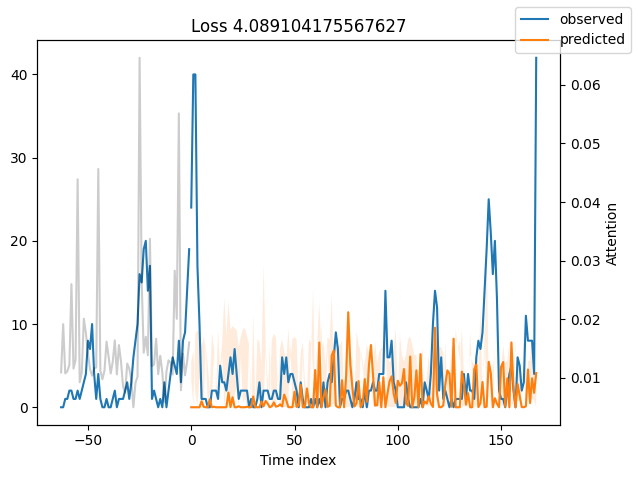

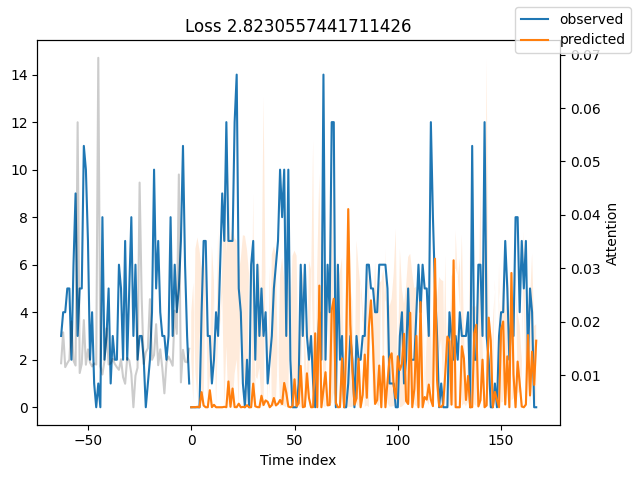

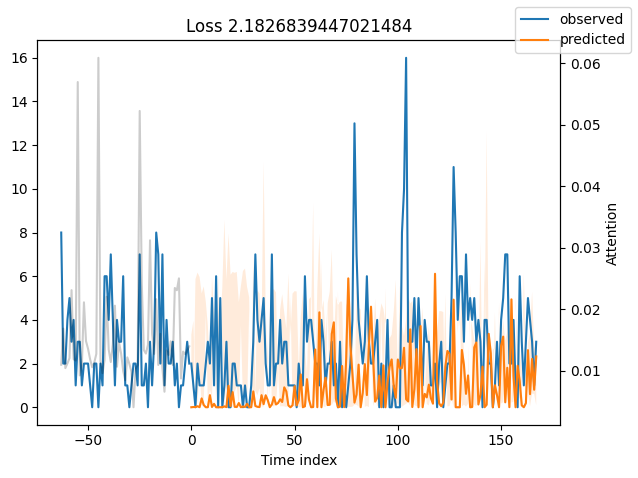

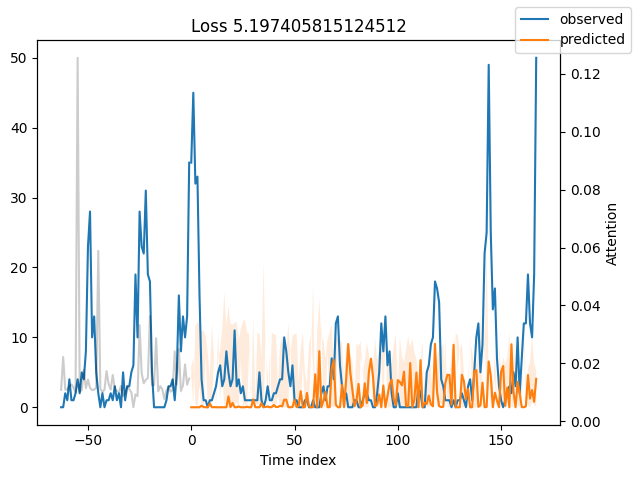

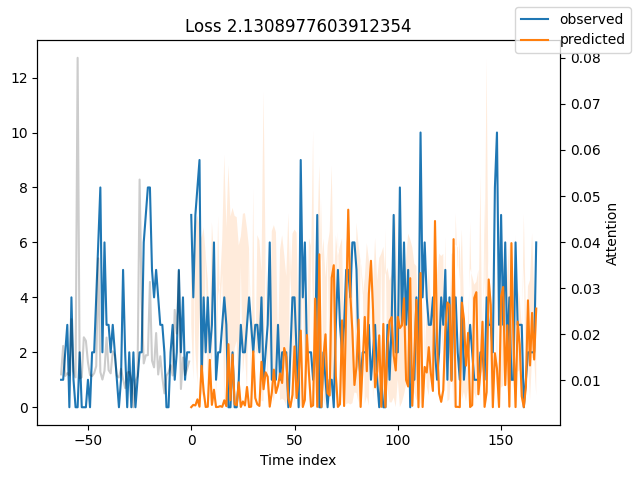

In [27]:
# plot random sample
# plot_locations = random.sample(range(0, pred.shape[0]), 10)
plot_locations = [25, 41, 14, 24, 4]
for idx in plot_locations:
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)

## Deploy a model from checkpoint using Ray Serve
<a class="anchor" id="deploy_model"></a>

Coding steps for Deployment:
- **Step 1**. Restore a model using Ray AIR checkpoints.
- **Step 2**.  Create some test data.
- **Step 3**.  Define a Ray Serve deployment class by using a Ray decorator @serve.deployment.
- **Step 4**.  Deploy the model.
- **Step 5**.  Query the deployment and get the result.

For more details see [Ray AIR Predictors](https://docs.ray.io/en/latest/ray-air/predictors.html) and [Ray Serve](https://docs.ray.io/en/latest/serve/getting_started.html) docs.

In [29]:
# Get location to saved model.
# model_dir = "/home/ray/ray_results/ptf_nyc/train_model_5ed81_00005_5_lr=0.0500,sample_cluster_id=erratic_2023-01-04_21-47-25/"
# checkpoint_path = "/home/ray/ray_results/ptf_nyc/train_model_5ed81_00005_5_lr=0.0500,sample_cluster_id=erratic_2023-01-04_21-47-25/checkpoint_000001/checkpoint"
print(model_dir)
print(model_path)

##########
# STEP 1. Restore a model from checkpoint.
##########
best_model = ptf.models.TemporalFusionTransformer.load_from_checkpoint(model_path)

/home/ray/ray_results/ptf_nyc/train_model_5ed81_00005_5_lr=0.0500,sample_cluster_id=erratic_2023-01-04_21-47-25/
/home/ray/ray_results/ptf_nyc/train_model_4ba60_00004_4_lr=0.0050,sample_cluster_id=erratic_2023-01-04_21-25-04/checkpoint_000001/checkpoint


In [30]:
##########
# STEP 2. Create some test data. 
##########

# Being lazy, repeat the last validation data as test data
max_prediction_length = FORECAST_CONFIG['forecast_horizon']
new_prediction_data = df.copy()
new_prediction_data["time_idx"] = new_prediction_data["time_idx"] + max_prediction_length

# Convert data from pandas to PyTorch tensors.
print(f"Input data type: {type(df)}")
_, _, test_loader = convert_pandas_pytorch_timeseriesdata(
    new_prediction_data, FORECAST_CONFIG
)
# Checkpoint a custom object.
pickle_dir = model_dir + "test_loader.pickle"
with open(pickle_dir, 'wb') as handle:
    pickle.dump(validation_loader, handle)
    
# Restore a test loader from pickle file.
filename = model_dir + "test_loader.pickle"
with open(filename, 'rb') as handle:
    test_loader = pickle.load(handle)

Input data type: <class 'pandas.core.frame.DataFrame'>


In [33]:
##########
# STEP 3. Define a Ray Serve deployment class.
##########
@serve.deployment
class ForecastPredictor:
    def __init__(self, model, test_data):
        self.model = model
        self.test_data = test_data
        
    def predict(self):
        raw_predictions, x = \
          self.model.predict(self.test_data, mode="raw", return_x=True)
        return x, raw_predictions

    def __call__(self):
        x, raw_predictions = self.predict()
        return [x, raw_predictions]

##########
# STEP 4. Deploy the model.
##########
# Bind arguments to the Class constructor.
my_first_deployment = ForecastPredictor.bind(
    model=best_model,
    test_data=test_loader)

##########
# STEP 5. Query the deployment and get the result.
##########
# Get handle from serve.run().
handle = serve.run(my_first_deployment)

# ray.get() the results from the handle.
ray_return = ray.get(handle.remote())
new_x = ray_return[0]
new_pred = ray_return[1]

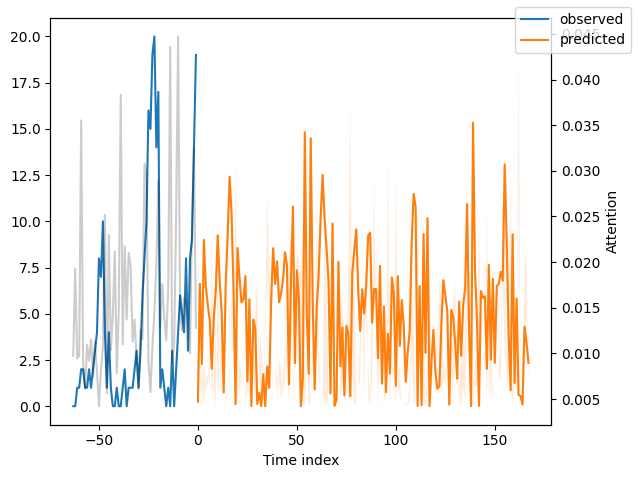

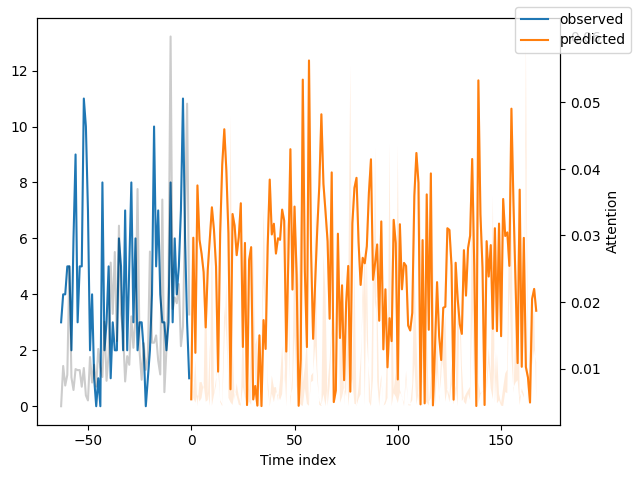

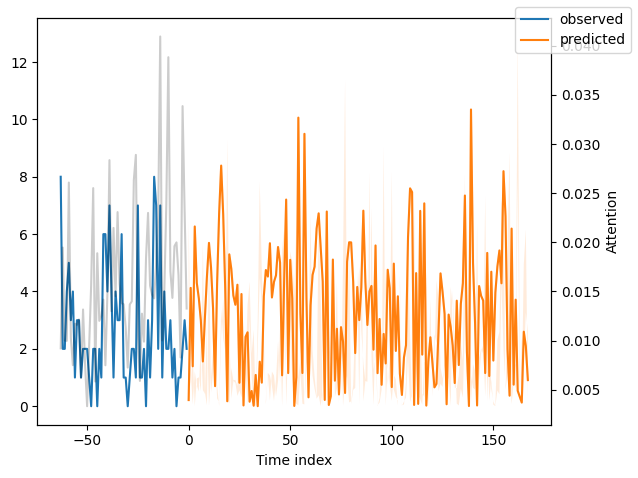

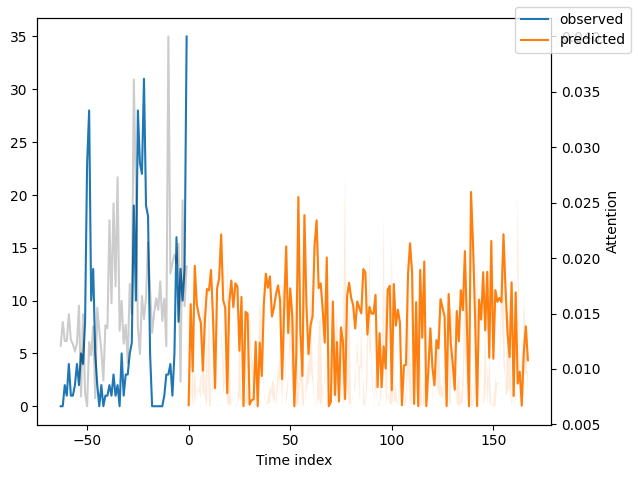

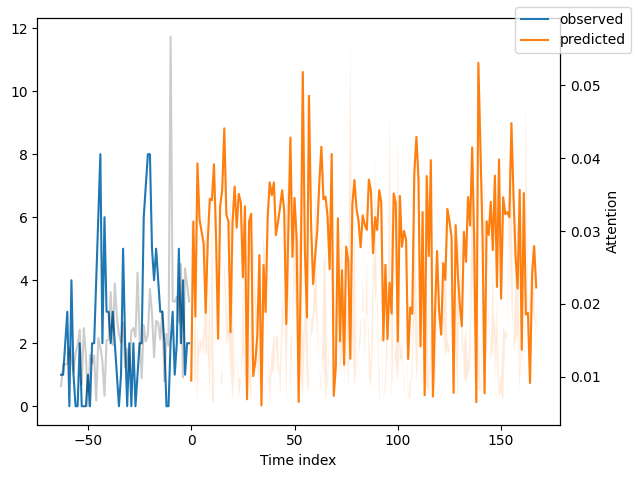

In [34]:
# Plot predictions from deployed model.
for idx in plot_locations:
    best_model.plot_prediction(new_x, new_pred, idx=idx, show_future_observed=False)